In [1]:
!python -m pip install --user --upgrade pip
!pip install --user keras
!pip install --user tensorflow
!pip install --user -U numpy

  Using cached https://files.pythonhosted.org/packages/8d/07/f7d7ced2f97ca3098c16565efbe6b15fafcba53e8d9bdb431e09140514b0/pip-19.2.2-py2.py3-none-any.whl


distributed 1.21.8 requires msgpack, which is not installed.
tensorboard 1.14.0 has requirement setuptools>=41.0.0, but you'll have setuptools 39.1.0 which is incompatible.


Requirement already up-to-date: numpy in c:\users\mayingzh\appdata\roaming\python\python36\site-packages (1.17.0)


In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU
from keras.layers.advanced_activations import PReLU, ELU
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as skm, math
import matplotlib.pyplot as plt
import seaborn as sns

C:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\mayingzh\AppData\R

## Load data and do data normalization

In [2]:
def moneyness(S,X):
    return S/X

In [3]:
def intrinsic(S, K, C, P):
    return C*(max(S-K, 0)) + P*(max(K-S, 0))

In [19]:
def load_data(file):
    df = pd.read_csv(file)
    df = df.dropna()
    
    # Remove the option data has less than 7 days to maturity.
    df = df[df.maturity > 6]
    
    df['moneyness'] = df.apply(lambda row: moneyness(row['underlying_price'], row['strike_price']), axis = 1)
    df = df[df.moneyness >= 0.5]
    df = df[df.moneyness <= 1.5]
    
    # Calculate the intrinsic value of all the options
    df['intrinsic'] = df.apply(lambda row: intrinsic(row['underlying_price'], row['strike_price'], row['cp_flag_C'], row['cp_flag_P']), axis = 1)
    
    sample_df = df[['strike_price', 'underlying_price', 'maturity', 'impl_volatility', 'realized_vol', 'cp_flag_C', 'cp_flag_P', 
                    'interest_rate', 'intrinsic', 'moneyness', 'best_offer']].apply(pd.to_numeric)
    sample_df = sample_df.reset_index(drop=True)
    
    return sample_df

In [5]:
sample_df = load_data('Options_R_new.csv')
sample_df.head()

,strike_price,underlying_price,maturity,impl_volatility,realized_vol,cp_flag_C,cp_flag_P,interest_rate,intrinsic,moneyness,best_offer
0,50.0,58.61,18,0.365853,0.169029,1,0,0.001,8.61,1.172200,8.70
1,52.5,58.61,18,0.294871,0.169029,1,0,0.001,6.11,1.116381,6.20
2,55.0,58.61,18,0.252262,0.169029,1,0,0.001,3.61,1.065636,3.85
3,57.5,58.61,18,0.214273,0.169029,1,0,0.001,1.11,1.019304,1.74
4,60.0,58.61,18,0.194355,0.169029,1,0,0.001,0.00,0.976833,0.46


In [45]:
def get_corr(sample_df):
    corr_matrix = sample_df.corr()
    
    fig = plt.figure(figsize = (10,10))
    sns.heatmap(corr_matrix, vmax = .8, square = True)
    plt.show()
    
    corr = corr_matrix['best_offer'].sort_values(ascending=False)
    print(corr)
    
    return corr

In [39]:
sample_df.shape

(1700235, 11)

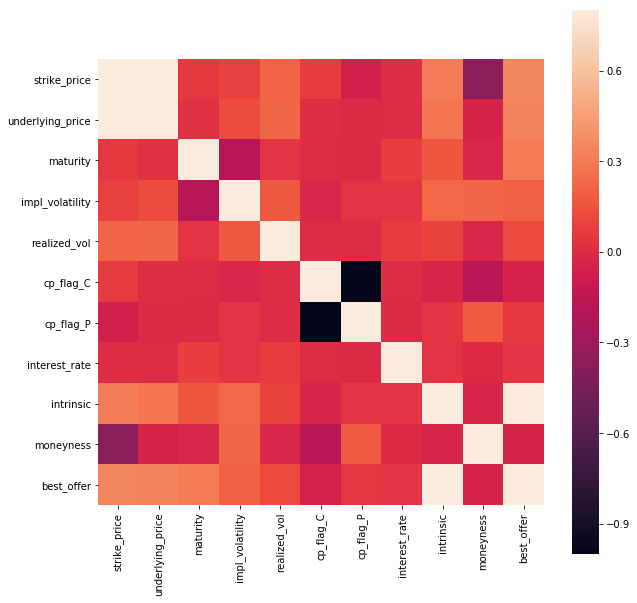

best_offer          1.000000
intrinsic           0.976694
strike_price        0.345604
underlying_price    0.332923
maturity            0.301267
impl_volatility     0.196128
realized_vol        0.118990
cp_flag_P           0.047227
interest_rate       0.038505
moneyness          -0.038097
cp_flag_C          -0.047227
Name: best_offer, dtype: float64


In [46]:
corr = get_corr(sample_df)

In [6]:
def data(s_df):
    
    y = s_df['best_offer'].values
    X = s_df[['strike_price', 'underlying_price', 'maturity', 'impl_volatility', 'cp_flag_C', 'cp_flag_P', 'interest_rate', 'intrinsic']]
    
    sc_X = StandardScaler()
    X_scale = sc_X.fit_transform(X)

    sc_y = StandardScaler()
    y = y.reshape(-1,1)
    y_scale = sc_y.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X_scale, y_scale, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [7]:
X_train, X_test, y_train, y_test = data(sample_df.sample(n=500000))

## Build a keras Sequential model

In [8]:
# Because it is a simple regression problem, we should custom metrics function
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis = -1))

def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

def mpe(y_true, y_pred):
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    errors = K.sqrt(K.mean((y_true-y_pred)**2))/K.mean(y_true)
    return errors

def exp(x):
    return K.exp(x)

In [9]:
def create_model():#neurons_1=1,learn_rate=0.01):
    
    model = Sequential()
    
    model.add(Dense(5, input_shape = (8,), activation = 'relu'))
    model.add(Dense(30, activation = 'relu'))
    model.add(Dense(60, activation = 'relu'))
    model.add(Dense(1, activation = 'linear'))
    
    optimizer = Adam(lr=0.01)
    model.compile(optimizer = optimizer, loss = 'mse', metrics = ['mae', r_square])
    
    return model

In [10]:
seed = 8
np.random.seed(seed)
model = KerasRegressor(build_fn=create_model, epochs=200, batch_size=128, verbose=2, validation_split = 0.1)
# neurons_1 = [30, 60]
# #neurons_2 = [20, 40, 60, 80]
# learn_rate = [0.01, 0.1, 0.2]
# param_grid = dict(learn_rate=learn_rate, neurons_1 = neurons_1)
# grid = GridSearchCV(estimator=model, param_grid = param_grid, cv = 3, n_jobs=-1)
model.fit(X_train, y_train, verbose=2)

prediction = grid_result.predict(X_test)

# summarize results
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

W0819 19:22:54.443699  9880 deprecation_wrapper.py:119] From C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0819 19:22:54.456714  9880 deprecation_wrapper.py:119] From C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0819 19:22:54.461710  9880 deprecation_wrapper.py:119] From C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0819 19:22:54.522773  9880 deprecation_wrapper.py:119] From C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instea

Train on 360000 samples, validate on 40000 samples
Epoch 1/200
 - 2s - loss: 0.0097 - mean_absolute_error: 0.0552 - r_square: 0.9895 - val_loss: 0.0032 - val_mean_absolute_error: 0.0371 - val_r_square: 0.9965
Epoch 2/200
 - 2s - loss: 0.0030 - mean_absolute_error: 0.0356 - r_square: 0.9967 - val_loss: 0.0031 - val_mean_absolute_error: 0.0348 - val_r_square: 0.9967
Epoch 3/200
 - 2s - loss: 0.0027 - mean_absolute_error: 0.0336 - r_square: 0.9970 - val_loss: 0.0030 - val_mean_absolute_error: 0.0356 - val_r_square: 0.9968
Epoch 4/200
 - 2s - loss: 0.0024 - mean_absolute_error: 0.0316 - r_square: 0.9973 - val_loss: 0.0020 - val_mean_absolute_error: 0.0280 - val_r_square: 0.9978
Epoch 5/200
 - 2s - loss: 0.0024 - mean_absolute_error: 0.0311 - r_square: 0.9974 - val_loss: 0.0026 - val_mean_absolute_error: 0.0324 - val_r_square: 0.9972
Epoch 6/200
 - 2s - loss: 0.0022 - mean_absolute_error: 0.0296 - r_square: 0.9976 - val_loss: 0.0022 - val_mean_absolute_error: 0.0313 - val_r_square: 0.9976
E

Epoch 53/200
 - 2s - loss: 0.0017 - mean_absolute_error: 0.0266 - r_square: 0.9981 - val_loss: 0.0019 - val_mean_absolute_error: 0.0276 - val_r_square: 0.9980
Epoch 54/200
 - 2s - loss: 0.0018 - mean_absolute_error: 0.0269 - r_square: 0.9980 - val_loss: 0.0016 - val_mean_absolute_error: 0.0257 - val_r_square: 0.9983
Epoch 55/200
 - 2s - loss: 0.0018 - mean_absolute_error: 0.0266 - r_square: 0.9981 - val_loss: 0.0018 - val_mean_absolute_error: 0.0272 - val_r_square: 0.9981
Epoch 56/200
 - 2s - loss: 0.0017 - mean_absolute_error: 0.0264 - r_square: 0.9981 - val_loss: 0.0014 - val_mean_absolute_error: 0.0241 - val_r_square: 0.9985
Epoch 57/200
 - 2s - loss: 0.0018 - mean_absolute_error: 0.0266 - r_square: 0.9980 - val_loss: 0.0015 - val_mean_absolute_error: 0.0246 - val_r_square: 0.9984
Epoch 58/200
 - 2s - loss: 0.0017 - mean_absolute_error: 0.0264 - r_square: 0.9981 - val_loss: 0.0016 - val_mean_absolute_error: 0.0275 - val_r_square: 0.9982
Epoch 59/200
 - 2s - loss: 0.0017 - mean_absol

Epoch 105/200
 - 2s - loss: 0.0018 - mean_absolute_error: 0.0265 - r_square: 0.9981 - val_loss: 0.0018 - val_mean_absolute_error: 0.0283 - val_r_square: 0.9981
Epoch 106/200
 - 2s - loss: 0.0017 - mean_absolute_error: 0.0262 - r_square: 0.9981 - val_loss: 0.0023 - val_mean_absolute_error: 0.0315 - val_r_square: 0.9975
Epoch 107/200
 - 2s - loss: 0.0017 - mean_absolute_error: 0.0263 - r_square: 0.9981 - val_loss: 0.0015 - val_mean_absolute_error: 0.0250 - val_r_square: 0.9984
Epoch 108/200
 - 2s - loss: 0.0017 - mean_absolute_error: 0.0263 - r_square: 0.9981 - val_loss: 0.0022 - val_mean_absolute_error: 0.0288 - val_r_square: 0.9977
Epoch 109/200
 - 2s - loss: 0.0017 - mean_absolute_error: 0.0261 - r_square: 0.9981 - val_loss: 0.0017 - val_mean_absolute_error: 0.0262 - val_r_square: 0.9982
Epoch 110/200
 - 2s - loss: 0.0017 - mean_absolute_error: 0.0263 - r_square: 0.9981 - val_loss: 0.0016 - val_mean_absolute_error: 0.0245 - val_r_square: 0.9982
Epoch 111/200
 - 2s - loss: 0.0017 - mea

Epoch 157/200
 - 2s - loss: 0.0018 - mean_absolute_error: 0.0266 - r_square: 0.9980 - val_loss: 0.0015 - val_mean_absolute_error: 0.0255 - val_r_square: 0.9983
Epoch 158/200
 - 2s - loss: 0.0017 - mean_absolute_error: 0.0261 - r_square: 0.9981 - val_loss: 0.0016 - val_mean_absolute_error: 0.0255 - val_r_square: 0.9983
Epoch 159/200
 - 2s - loss: 0.0018 - mean_absolute_error: 0.0266 - r_square: 0.9980 - val_loss: 0.0026 - val_mean_absolute_error: 0.0302 - val_r_square: 0.9973
Epoch 160/200
 - 2s - loss: 0.0017 - mean_absolute_error: 0.0260 - r_square: 0.9981 - val_loss: 0.0019 - val_mean_absolute_error: 0.0272 - val_r_square: 0.9980
Epoch 161/200
 - 2s - loss: 0.0017 - mean_absolute_error: 0.0261 - r_square: 0.9981 - val_loss: 0.0016 - val_mean_absolute_error: 0.0254 - val_r_square: 0.9983
Epoch 162/200
 - 2s - loss: 0.0017 - mean_absolute_error: 0.0262 - r_square: 0.9981 - val_loss: 0.0016 - val_mean_absolute_error: 0.0266 - val_r_square: 0.9983
Epoch 163/200
 - 2s - loss: 0.0017 - mea

AttributeError: 'History' object has no attribute 'predict'

In [35]:
model.model.save('model4_0.h5')

In [11]:
prediction = model.predict(X_test)
print(y_test)
print(prediction)
#print(sc_Y.inverse_transform(prediction))

[[-0.19961926]
 [-0.57476429]
 [ 0.07780588]
 ...
 [ 0.67820356]
 [-0.51099792]
 [-0.41410615]]
[-0.16397303 -0.5618566   0.19312209 ...  0.6620499  -0.4943426
 -0.3716166 ]


In [16]:
def mean_percent_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    errors = np.sqrt(np.mean((y_true-y_pred)**2))/np.mean(y_true)
    return errors

In [18]:
#print("Average precentage error:       %f" % mean_percent_error(y_test, prediction))
print("Mean absolute error (MAE):      %f" % skm.mean_absolute_error(y_test,prediction))
print("Mean squared error (MSE):       %f" % skm.mean_squared_error(y_test,prediction))
print("Root mean squared error (RMSE): %f" % math.sqrt(skm.mean_squared_error(y_test,prediction)))
print("R square (R^2):                 %f" % skm.r2_score(y_test,prediction))

Mean absolute error (MAE):      0.027516
Mean squared error (MSE):       0.001718
Root mean squared error (RMSE): 0.041451
R square (R^2):                 0.998291


## Reference: 
&emsp;&emsp;What does 'Accuracy' mean in Regression? https://github.com/keras-team/keras/issues/7947 <br>
&emsp;&emsp;https://keras.io/metrics/<br>
&emsp;&emsp;Scale, Standardize, or Normalize with Scikit-Learn https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02 <br>
&emsp;&emsp;The Day my Computer Won the Nobel Prize (Neural Network Option Pricing)  https://medium.com/datadriveninvestor/the-day-my-computer-won-the-nobel-prize-neural-network-option-pricing-d29b4379f1d2 <br>